# Introduction to LangChain for AI-based applications - STK Jalasoft


## Logistics

Installation of required packages

In [ ]:
# pip install langchain openai langchain-openai tiktoken transformers python-dotenv 

Load .env file

In [1]:
from dotenv import load_dotenv
load_dotenv('.git/.env')

True

Define to_markdown function

In [2]:
from IPython.display import display
from IPython.display import Markdown
import textwrap


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

## Connecting to LLMs using LangChain

Temperature of 0

In [3]:
from langchain_openai import OpenAI

llm = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0)

prompt = "What would be a good company name for a company that makes salteñas?"

to_markdown(llm.invoke(prompt))

> 
> 
> "Sabor Boliviano" (Bolivian Flavor)

Temperature of 0.9

In [5]:
from langchain_openai import OpenAI

llm = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0.9)

prompt = "What would be a good company name for a company that makes salteñas?"

to_markdown(llm.invoke(prompt))

> 
> 
> "Sabor Boliviano" (Bolivian Flavor) 
> "La Salteñeria" (The Salteña Factory) 
> "El Rincon de las Salteñas" (The Salteña Corner) 
> "Salteñas del Cielo" (Salteñas from Heaven) 
> "La Casa de las Salteñas" (The House of Salteñas) 
> "Tradición Salteña" (Salteña Tradition) 
> "El Sabor Auténtico" (The Authentic Flavor) 
> "Delicias Salteñas" (Salteña Delights) 
> "Rico & Auténtico" (Rich & Authentic) 
> "Salteñas Gourmet" (Gourmet Salteñas)

# Tokenization
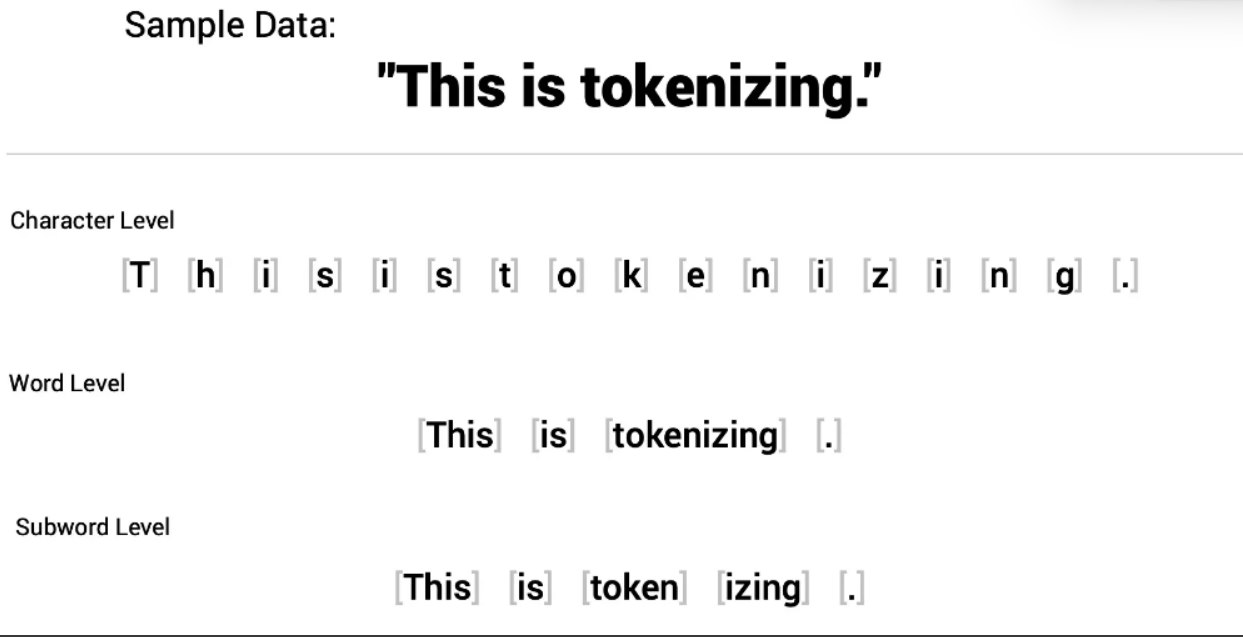

In [4]:
from transformers import AutoTokenizer

# Download and load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

c:\Users\sebastian.villanueva\Anaconda3\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [5]:
token_ids = tokenizer.encode("Testing the tokenizer with sample text.")

print("Tokens:   ", tokenizer.convert_ids_to_tokens(token_ids))
print("Token IDs:", token_ids)

Tokens:    ['Testing', 'Ġthe', 'Ġtoken', 'izer', 'Ġwith', 'Ġsample', 'Ġtext', '.']
Token IDs: [44154, 262, 11241, 7509, 351, 6291, 2420, 13]


In [6]:
from langchain_openai import OpenAI
from langchain.callbacks import get_openai_callback

llm = OpenAI(model = "gpt-3.5-turbo-instruct", temperature=0)
prompt = "Which is the capital of France?"
# prompt = "Tell me 20 historical facts about the capital of France"

with get_openai_callback() as cb:
  result = llm.invoke(prompt)
  print(cb)

Tokens Used: 9
	Prompt Tokens: 7
	Completion Tokens: 2
Successful Requests: 1
Total Cost (USD): $1.45e-05


### Tokenization shortcomings
*   **Uppercase/Lowercase Words:** “hello” -> ***31373*** || “HELLO” -> **[13909, 3069, 46]** which translates to [“HE”, “LL”, “O”].
*  **Dealing with Numbers:**  200 represented as one token || 201 is represented as two tokens **[20, 1]**.
*   **Trailing whitespace:** Certain tokens begin with a special character (Ġ) representing whitespace, while others lack this feature.

## Prompting in LangChain

`PromptTemplate` is a predefined structure or pattern used to construct effective and consistent prompts for large language models. It is a guideline to ensure the input text or prompt is properly formatted.

The template is a formatted string with a {query} placeholder that will be substituted with a real question when applied. To create a PromptTemplate object, two arguments are required:

1.  `input_variables`: A list of variable names in the template; in this case, it includes only the query.
2.  `template`: The template string containing formatted text and placeholders.

After creating the PromptTemplate object, it can be used to produce prompts with specific questions by providing input data. The input data is a dictionary where the key corresponds to the variable name in the template. The resulting prompt can then be passed to a language model to generate answers.

In [7]:
from langchain import LLMChain, PromptTemplate
from langchain_openai import ChatOpenAI

class PromptTemplateExample:
    def  __init__(self):
        self.llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
        self.template = """
        Answer the question only based on the context below. If the
        question cannot be answered using the information provided, answer
        with "I don't know".
        
        Context: Jalasoft was born with the vision of providing talented software engineers to the United States. The entire team consisted of 6 people back then.
        ...
        Question: {query}
        Answer: 
        """

        self.prompt_template = PromptTemplate(
            input_variables=["query"],
            template=self.template
        )
        
        self.chain = LLMChain(
            llm=self.llm,
            prompt=self.prompt_template
        )
        
    def input_query(self, query):
        response = self.chain.invoke({"query": query})
        return response

In [9]:
chat = PromptTemplateExample()
# my_response = chat.input_query("How many people were in Jalasoft's first team?")
my_response = chat.input_query("In which country Jalasoft has their LATAM headquarters?")
to_markdown("Question: " + my_response['query'] + "\n\n" + "Answer: " + my_response['text'])

> Question: In which country Jalasoft has their LATAM headquarters?
> 
> Answer: I don't know.

In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
prompt = "In which country Jalasoft has their LATAM headquarters?"

response = llm.invoke(prompt)
to_markdown(response.content)

> Jalasoft has their LATAM headquarters in Bolivia.

**Few-shot prompting** can lead to improved output quality because the model can learn the task better by observing examples

This approach involves using the ``FewShotPromptTemplate`` class, which takes in a ``PromptTemplate`` and a list of a few shot examples. The class formats the prompt template with a few shot examples, which helps the language model generate a better response.

In [12]:
from langchain import LLMChain, PromptTemplate, FewShotPromptTemplate
from langchain_openai import ChatOpenAI

class OpenAIChat:
    def  __init__(self):
        self.llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
        
        self.examples = [
            {
                "query": "How do I become a better programmer?",
                "answer": "Try talking to a rubber duck; it works wonders."
            },
            {
                "query": "Why is the sky blue?",
                "answer": "It's nature's way of preventing eye strain."
            }
        ]

        
        self.example_template = """
        User: {query}
        AI: {answer}
        """

        self.example_prompt = PromptTemplate(
            input_variables=["query", "answer"],
            template=self.example_template
        )
        
        self.prefix = """The following are excerpts from conversations with an AI
        assistant. Please answer the upcoming questions using the same sarcastic and witty style as the given examples. 
        Here are some examples: 
        """
        self.suffix = """
        User: {query}
        AI: """
        
        self.dynamic_prompt = FewShotPromptTemplate(
            examples=self.examples,
            example_prompt=self.example_prompt,
            prefix=self.prefix,
            suffix=self.suffix,
            input_variables=["query"],
            example_separator="\n\n"
        )
        
        self.chain = LLMChain(
            llm=self.llm,
            prompt=self.dynamic_prompt
        )
        
    def input_query(self, query):
        response = self.chain.invoke({"query": query})
        return response

In [13]:
chat = OpenAIChat()
query = "How can I learn to build AI-based applications using LangChain?"
response = chat.input_query(query)

to_markdown("User: " + response["query"] + "\n\n" + "AI: " + response["text"])

> User: How can I learn to build AI-based applications using LangChain?
> 
> AI: Oh, just sprinkle some fairy dust on your computer and hope for the best.

## Output Parsers

While the language models can only generate textual outputs, a predictable data structure is always preferred in a prod environment. A problem is the lack of a method to extract relevant information from an output string dynamically. There is no guarantee that the response have the same format every time.

**Output Parsers** help create a data structure to define the expectations from the output precisely. We can ask for a list of words in case of the word suggestion application or a combination of different variables like a word and the explanation of why it fits.

In [17]:
from typing import List
from pydantic import BaseModel, Field, validator
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI

class Suggestions(BaseModel):
    words: List[str] = Field(description="list of substitutes words based on context")
    definitions: List[str] = Field(description="the definition of every proposed word")
    
    @validator("words")
    def not_start_with_number(cls, field):
        for item in field:
            if item[0].isnumeric():
                raise ValueError(f"The word '{item}' starts with a number.")
        return field
    
    @validator("words", "definitions")
    def starts_with_capital_letter(cls, field):
        for idx, item in enumerate(field):
            if item[0].islower():
                field[idx] = item.capitalize()
        return field
    
    @validator("definitions")
    def ends_with_dot(cls, field):
        for idx, item in enumerate(field):
            if item[-1] != ".":
                field[idx] += "."
        return field

class SuggestionsParser(PydanticOutputParser):
    def __init__(self):
        super().__init__(pydantic_object=Suggestions)

class SuggestionsPrompt(PromptTemplate):
    def __init__(self):
        parser = SuggestionsParser()
        super().__init__(
            template="""
            Offer a list of suggestions to substitute the specified target_word based on the presented context and also provide the definitions for every single word.
            {format_instructions}
            target_word={target_word}
            context={context}
            """,
            input_variables=["target_word", "context"],
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )

class SuggestionsModel(OpenAI):
    def __init__(self, model_name="gpt-3.5-turbo-instruct", temperature=0):
        super().__init__(model_name=model_name, temperature=temperature)

    def get_suggestions(self, target_word, context):
        prompt = SuggestionsPrompt()
        model_input = prompt.format_prompt(
            target_word=target_word,
            context=context
        )
        output = self(model_input.to_string())
        parser = SuggestionsParser()
        return parser.parse(output)

In [18]:
model = SuggestionsModel()
target_word = "sleeping"
context = "I was sleeping when the fire started in my building"

suggestions = model.get_suggestions(target_word, context)
print(suggestions)

words=['Resting', 'Dozing', 'Slumbering', 'Napping'] definitions=['To be in a state of rest.', 'To sleep lightly.', 'To be in a deep sleep.', 'To sleep for a short period of time.']


## Indexes and Retrievers in LangChain
An `index` is a powerful data structure that meticulously organizes and stores documents to enable efficient searching, while a `retriever` leverages the index to locate and return relevant documents in response to user queries. In LangChain, the main types of indexes focus on vector databases, with embedding-based indexes being the most prevalent.

Retrievers focus on extracting relevant documents to merge with prompts for language models. A retriever exposes a `get_relevant_documents` method, which accepts a query string as input and returns a list of related documents.

In [33]:
from langchain.document_loaders import SeleniumURLLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import DeepLake
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

class DocumentProcessor:
    def __init__(self, urls):
        self.urls = urls

    def load_data(self):
        loader = SeleniumURLLoader(urls=self.urls)
        return loader.load()

    def split_documents(self, data):
        text_splitter = CharacterTextSplitter(chunk_size=700, chunk_overlap=20)
        return text_splitter.split_documents(data)

class DeepLakeManager:
    def __init__(self, dataset_path):
        embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
        self.db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

    def add_documents(self, docs):
        self.db.add_documents(docs)

    def get_retriever(self):
        return self.db.as_retriever()

class QAChainManager:
    def __init__(self, llm, retriever):
        self.qa_chain = RetrievalQA.from_chain_type(llm=llm,
                                                    chain_type="stuff",
                                                    retriever=retriever)

    def execute_query(self, query):
        return self.qa_chain.run(query)

In [31]:
# Example usage
urls = ["https://eldeber.com.bo/dinero/escasez-de-dolares-resta-competitividad-a-las-empresas-constructoras-bolivianas-ante-las-extranjeras_357415"]
document_processor = DocumentProcessor(urls)
data = document_processor.load_data()
docs = document_processor.split_documents(data)

db_manager = DeepLakeManager(dataset_path="hub://sebvillanueva9/stk-example2")
db_manager.add_documents(docs)
retriever = db_manager.get_retriever()

Using embedding function is deprecated and will be removed in the future. Please use embedding instead.


Your Deep Lake dataset has been successfully created!


Creating 10 embeddings in 1 batches of size 10:: 100%|██████████| 1/1 [00:15<00:00, 15.65s/it]

Dataset(path='hub://sebvillanueva9/stk-example2', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype      shape      dtype  compression
  -------    -------    -------    -------  ------- 
   text       text      (10, 1)      str     None   
 metadata     json      (10, 1)      str     None   
 embedding  embedding  (10, 1536)  float32   None   
    id        text      (10, 1)      str     None   


In [32]:
llm = OpenAI(model="gpt-3.5-turbo-instruct")
qa_chain_manager = QAChainManager(llm=llm, retriever=retriever)

query = "Cual es el nombre del presidente del Colegio de Ingenieros Civiles de Santa Cruz?"
response = qa_chain_manager.execute_query(query)
to_markdown(response)

>  Alberto Rendón.

## Giving memory to LLMs

In [73]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationSummaryMemory, ConversationSummaryBufferMemory
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAI

class AIConversation:
    def __init__(self, llm):
        self.llm = llm
        self.memory = ConversationSummaryMemory(llm=self.llm)
        self.verbose = True

    def initiate_chain(self):
        return ConversationChain(llm=self.llm, memory=self.memory, verbose=self.verbose)

llm = OpenAI(temperature=0)

conversation_instance = AIConversation(llm=llm)
conversation_with_summary = conversation_instance.initiate_chain()

input1 = "Hey, have you heard about the movie Schindler's List?"
input2 = "Do you know where was the movie filmed?"

response1 = conversation_with_summary.predict(input=input1)
response2 = conversation_with_summary.predict(input=input2)

to_markdown("Human: " +  input1 + "\n\n" + "AI: " + response1 + "\n\n" + "Human: " + input2 + "\n\n" +"AI: " + response2)




> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hey, have you heard about the movie Schindler's List?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

The human asks if the AI has heard of the movie Schindler's List. The AI responds with information about the film, including its release date, director, and plot. The film received critical acclaim and won seven Academy Awards. The AI also asks if there is anything sp

> Human: Hey, have you heard about the movie Schindler's List?
> 
> AI:  Yes, I have heard of Schindler's List. It is a historical drama film directed and produced by Steven Spielberg. It was released in 1993 and is based on the true story of Oskar Schindler, a German businessman who saved the lives of over a thousand Jewish refugees during the Holocaust. The film received critical acclaim and won seven Academy Awards, including Best Picture and Best Director. Is there anything specific you would like to know about the movie?
> 
> Human: Do you know where was the movie filmed?
> 
> AI:  Yes, Schindler's List was filmed primarily in Poland, specifically in Krakow and the surrounding areas. Some scenes were also filmed in Germany and Israel. Is there anything else you would like to know about the movie?

## Agents and Tools

In [86]:
from langchain_openai import OpenAI
from langchain.agents import Tool
from langchain.utilities import GoogleSearchAPIWrapper
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import initialize_agent, AgentType

class TextSummarizationAgent:
    def __init__(self):
        self.llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)

        self.prompt = PromptTemplate(
            input_variables=["query"],
            template="Write a summary in spanish of the following text: {query}"
        )

        self.summarize_chain = LLMChain(llm=self.llm, prompt=self.prompt)

        self.search_tool = Tool(
            name="Search",
            func=GoogleSearchAPIWrapper().run,
            description="Useful for finding information about recent events"
        )

        self.summarizer_tool = Tool(
            name="Text summarizer",
            func=self.summarize_chain.run,
            description="Useful for summarizing texts"
        )

        self.tools = [self.search_tool, self.summarizer_tool]

        self.agent = initialize_agent(
            self.tools,
            self.llm,
            agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
            verbose=True
        )

    def process_request(self, query):
        response = self.agent(query)
        return response["output"]

In [87]:
agent = TextSummarizationAgent()
query = "What's the latest news about Real Madrid? Please summarize the results in Spanish."
result = agent.process_request(query)
print(result)



> Entering new AgentExecutor chain...
 I should use the search tool to find recent news about Real Madrid.
Action: Search
Action Input: "Real Madrid news"
Observation: Official Real Madrid channel. All the Real Madrid information with news, players, ticket sales, member services and club information. Get updates on the latest Real Madrid News and enjoy our posts, videos and analysis on Marca English, the reference on Real Madrid News. Official Real Madrid channel. All the Real Madrid information with news, players, ticket sales, member services and club information. Get all the breaking Real Madrid news. Headlines linking to the best sites from around the web. Updates 24/7/365. The #1 Real Madrid news resource. Your best source for quality Real Madrid news, rumors, analysis, stats and scores from the fan perspective. Real Madrid logo. Real Madrid · Bellingham Expected Back for 2nd Leg · Mbappé Agrees Madrid Deal · Mbappé Agrees Madrid Deal · Mbappé Reached 300 Faster ... Real Madrid 

In [ ]:
%load_ext autoreload
%autoreload 2